In [160]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import datetime 
import requests 
from urllib.parse import urlencode
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import levene

1. [Retention](#retention)  
1.1. [EDA](#EDA)  
1.2. [Реализация функции по расчету Retention](#function)
2. [A/B тестирование](#AB)

## Вводные данные: ##
Для компании, которая **разрабатывает мобильные игры**, необходимо: 
1. написать функцию, которая будет считать **retention игроков (по дням от даты регистрации игрока)**. Данные лежат в папке shared. 
2. проанализировать результаты А/В тестирования наборов акционных предложений. На основе имеющихся данных определить, **какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение**.

<a name="retention"></a> 
## 1. Расчет Retention ##

**Загрузка данных**

In [2]:
reg_data = pd.read_csv('/Users/macuser/Downloads/problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('/Users/macuser/Downloads/problem1-auth_data.csv', sep = ';')

<a name="EDA"></a> 
## EDA (предварительный анализ данных) ##

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

Преобразуем сразу столбцы с датами в соответствущий тип данных. 

In [6]:
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.to_period('D')

In [7]:
auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.to_period('D')

In [8]:
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [9]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


Начнем EDA двух дата-фреймов с исследования данных на дубликаты и пропущенные значения. 

**Проверка на пропущенные значения**

In [10]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [11]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

**Проверка на дублирующиеся значения**

In [12]:
reg_data.duplicated().sum()

0

In [13]:
reg_data.uid.duplicated().sum()

0

In [14]:
auth_data.duplicated().sum()

0

In [15]:
auth_data.loc[auth_data.auth_ts.duplicated()]
# ok 

,auth_ts,uid
42,2000-01-13,3
226,2001-12-30,12
238,2002-02-13,2
280,2002-06-15,15
295,2002-07-20,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [30]:
reg_data.shape

(1000000, 2)

In [31]:
auth_data.shape

(9601013, 2)

In [32]:
auth_data.describe(include='all')

,auth_ts,uid
count,9601013,9.601013e+06
unique,6169,NaN
top,2020-09-21,NaN
freq,15948,NaN
mean,NaN,3.347198e+05
std,NaN,2.832669e+05
min,NaN,1.000000e+00
25%,NaN,9.599700e+04
50%,NaN,2.579210e+05
75%,NaN,5.190250e+05


In [33]:
reg_data.describe(include='all')

,reg_ts,uid
count,1000000,1.000000e+06
unique,5110,NaN
top,2020-09-22,NaN
freq,1641,NaN
mean,NaN,5.552354e+05
std,NaN,3.206011e+05
min,NaN,1.000000e+00
25%,NaN,2.776438e+05
50%,NaN,5.550455e+05
75%,NaN,8.329712e+05


Видим, что временной промежуток двух фреймов совпадает. 

In [34]:
 set(reg_data.uid) == set(auth_data.uid)

True

Уникальные айдишники совпадают. 

Видим, что временной промежуток начинается с 1998 года и заканчивается 2020 годом, хотя данных не так много для такого диапазона. Посмотрим на гистограмму по годам двух дата-сетов. 

<Axes: xlabel='reg_ts', ylabel='Count'>

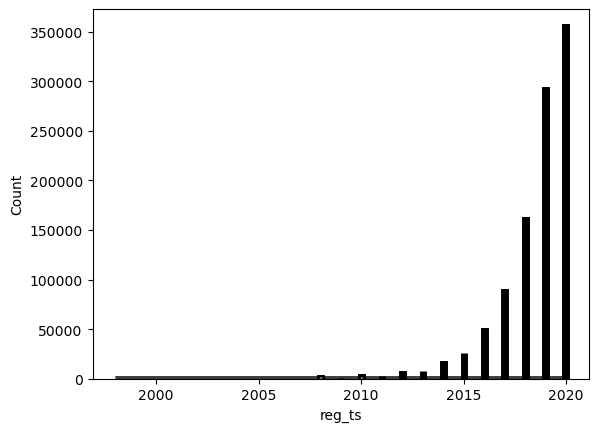

In [35]:
sns.histplot(reg_data['reg_ts'].dt.year, linewidth=5)

<Axes: xlabel='auth_ts', ylabel='Count'>

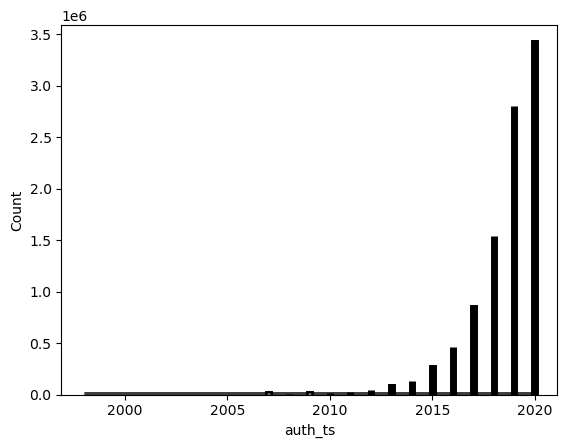

In [36]:
sns.histplot(auth_data['auth_ts'].dt.year, linewidth=5)

**NOTE:** Можно сделать вывод, что данных до 2015 года критически мало: стоит уточнить у владельца данных, корректны ли они, либо сделать оговорку при отправке результатов анализа, что лучше анализировать retention после 2015 года. 

Объединяем дата-фреймы для расчета retention. 

In [37]:
full_df = pd.merge(reg_data, auth_data, how = 'left', on = 'uid')

In [38]:
full_df.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [39]:
full_df.auth_ts.isna().sum()

0

Проверим, что ничего не потеряли и не задублировали при джойне. 

In [40]:
full_df.shape[0] == auth_data.shape[0]

True

Вычислим новый столбец с количеством дней от даты регистрации до времени заходов в игру. 

In [41]:
full_df['days_diff'] = (full_df.auth_ts.dt.to_timestamp() - full_df.reg_ts.dt.to_timestamp()).dt.days

In [42]:
full_df.head()

,reg_ts,uid,auth_ts,days_diff
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-22,2,1999-07-25,3
3,1999-07-22,2,1999-07-31,9
4,1999-07-22,2,1999-08-05,14


Создадим новый дата-фрейм для расчета retention. 

In [43]:
df_cohort = full_df.groupby(['reg_ts', 'days_diff'], as_index=False).uid.nunique()

In [44]:
df_cohort.head()

,reg_ts,days_diff,uid
0,1998-11-18,0,1
1,1999-07-22,0,1
2,1999-07-22,3,1
3,1999-07-22,9,1
4,1999-07-22,14,1


Для начала рассчитаем retention по шагам, без написания функции. 

In [45]:
cohort_pivot = df_cohort.pivot(index="reg_ts", columns="days_diff", values="uid").fillna(0)

In [46]:
cohort_size = cohort_pivot[0]

In [56]:
retention_rate = cohort_pivot.divide(cohort_size, axis=0)

In [57]:
retention_rate

days_diff,0,1,2,3,4,5,6,7,8,9,...,7701,7704,7706,7709,7712,7716,7720,7721,7727,7729
reg_ts,,,,,,,,,,,,,,,,,,,,,
1998-11-18,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-07-22,1.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-13,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-28,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-16,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,1.0,0.018360,0.035496,0.047124,0.034884,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-20,1.0,0.024450,0.043399,0.023839,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-21,1.0,0.018926,0.029915,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
retention_rate.drop(columns=0)

days_diff,1,2,3,4,5,6,7,8,9,10,...,7701,7704,7706,7709,7712,7716,7720,7721,7727,7729
reg_ts,,,,,,,,,,,,,,,,,,,,,
1998-11-18,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-07-22,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-13,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-28,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-16,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,0.018360,0.035496,0.047124,0.034884,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-20,0.024450,0.043399,0.023839,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-21,0.018926,0.029915,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Получилась общая таблица с расчетом retention без ограничения по временному промежутку (это нужно будет учесть при составлении функции для расчета retention) + учесть требования к стандартной визуализации данного показателя. 

<a name="function"></a> 
## Функция для расчета коэффициента retention ##

In [59]:
def retention_func(reg_data, auth_data, start_date, end_date): 
    # reg_data - таблица с датой регистрации пользователей    
    # auth_data - таблица с датой захода пользователей в игру
    # start_date - дата начала периода, за который рассчитывается Retention
    # end_date - дата конца периода, за который рассчитывается Retention
    
    # загружаем таблицы
    reg_data = pd.read_csv('/Users/macuser/Downloads/problem1-reg_data.csv', sep=';')
    auth_data = pd.read_csv('/Users/macuser/Downloads/problem1-auth_data.csv', sep=';')
    
    # уточняем формат временных столбцов
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.to_period('D')
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.to_period('D')
    
    # объединяем дата-фреймы (лефт-джойн к таблице регистрации, поскольку подразумеваем, что 
    # незарегистрированный пользователь не может войти в игру) 
    df_full = reg_data.merge(auth_data, how='left', on='uid')
    
    # учитываем необходимость фильтрации даты, чтобы задавать нужный временной промежуток для расчета 
    df_full = df_full.loc[(df_full["reg_ts"] >= start_date) & (df_full["auth_ts"] <= end_date)]
    
    # вычисляем столбец с разницой между датой авторизации и датой регистрации
    df_full["day_diff"] = (df_full.auth_ts.dt.to_timestamp() - df_full.reg_ts.dt.to_timestamp()).dt.days

    # группируем по дате регистрации и номеру периода, а затем подсчитываем уникальных пользователей
    df_cohort = df_full \
        .groupby(['reg_ts', 'day_diff'], as_index=False)\
        .nunique('uid')\
        .rename(columns={"uid": "counted_id"})

    cohort_pivot = df_cohort.pivot(index="reg_ts", columns="day_diff", values="counted_id").fillna(0)

    # рассчитываем размер когорты (нулевой день, когда пользователь только зарегистрировался в игре) 
    # и retention_rate
    cohort_size = cohort_pivot[0]
    retention_rate = cohort_pivot.divide(cohort_size, axis=0)
    retention_rate.insert(0, "cohort_size", cohort_pivot[0], False)
    retention_rate = retention_rate.drop(columns=0)

    # зададим параметры для визуализации данных
    df_final = (retention_rate
                .style
                .set_caption('Retention')                        # Название таблицы
                .background_gradient(cmap='viridis')             # Раскраска столбцов
                .highlight_null('white')                         # Белый фон, где есть NaN
                .format("{:.2%}", na_rep="")                     # Числа в виде процентов и без NaN
                .format(formatter={('cohort_size'): "{:.0f}"}))
    
    return df_final  

Проверим работоспособность функции на небольшом временном интервале

In [62]:
retention_func(reg_data, auth_data, "2019-01-01", "2019-02-01")

day_diff,cohort_size,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
reg_ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,583,0.020583,0.037736,0.049743,0.044597,0.063465,0.082333,0.058319,0.054889,0.060034,0.060034,0.046312,0.056604,0.034305,0.048027,0.046312,0.056604,0.048027,0.039451,0.046312,0.029160,0.054889,0.030875,0.042882,0.037736,0.032590,0.042882,0.036021,0.041166,0.029160,0.022298,0.015437
2019-01-02,583,0.017153,0.049743,0.036021,0.049743,0.080617,0.054889,0.070326,0.030875,0.041166,0.042882,0.058319,0.054889,0.049743,0.044597,0.046312,0.027444,0.048027,0.049743,0.041166,0.041166,0.036021,0.039451,0.036021,0.022298,0.032590,0.024014,0.039451,0.018868,0.030875,0.024014,0.000000
2019-01-03,585,0.017094,0.030769,0.044444,0.059829,0.063248,0.064957,0.058120,0.022222,0.049573,0.047863,0.068376,0.034188,0.046154,0.039316,0.049573,0.042735,0.044444,0.041026,0.030769,0.044444,0.034188,0.035897,0.023932,0.037607,0.042735,0.032479,0.042735,0.027350,0.022222,0.000000,0.000000
2019-01-04,585,0.027350,0.037607,0.042735,0.054701,0.054701,0.080342,0.052991,0.042735,0.052991,0.056410,0.064957,0.059829,0.041026,0.041026,0.056410,0.039316,0.039316,0.047863,0.039316,0.046154,0.042735,0.035897,0.032479,0.029060,0.044444,0.037607,0.037607,0.032479,0.000000,0.000000,0.000000
2019-01-05,586,0.018771,0.040956,0.046075,0.049488,0.081911,0.071672,0.069966,0.059727,0.040956,0.047782,0.064846,0.051195,0.058020,0.052901,0.040956,0.056314,0.040956,0.044369,0.030717,0.046075,0.042662,0.052901,0.027304,0.047782,0.029010,0.039249,0.040956,0.000000,0.000000,0.000000,0.000000
2019-01-06,588,0.017007,0.037415,0.052721,0.047619,0.059524,0.056122,0.057823,0.052721,0.047619,0.051020,0.061224,0.049320,0.039116,0.049320,0.051020,0.039116,0.037415,0.039116,0.042517,0.037415,0.027211,0.039116,0.035714,0.039116,0.037415,0.025510,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-07,588,0.017007,0.042517,0.040816,0.054422,0.073129,0.073129,0.066327,0.054422,0.054422,0.034014,0.068027,0.047619,0.052721,0.054422,0.039116,0.037415,0.039116,0.049320,0.028912,0.042517,0.039116,0.042517,0.035714,0.025510,0.034014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-08,589,0.030560,0.040747,0.050934,0.057725,0.071307,0.071307,0.066214,0.057725,0.039049,0.049236,0.052632,0.050934,0.054329,0.042445,0.042445,0.039049,0.049236,0.042445,0.050934,0.028862,0.044143,0.037351,0.037351,0.037351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-09,590,0.010169,0.027119,0.042373,0.052542,0.059322,0.064407,0.044068,0.057627,0.050847,0.044068,0.044068,0.040678,0.044068,0.035593,0.050847,0.038983,0.038983,0.032203,0.032203,0.027119,0.040678,0.038983,0.033898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<a name="AB"></a> 
## 2. Проверка результатов А/В тестирования ##

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

**Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?**

Используя API яндекс диска, скачиваем дата-сет и сохраняем его в дата-фрейм. 

In [71]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'


final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [68]:
df_ab_test = pd.read_csv(download_url, sep=';')

In [138]:
df_ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Посмотрим на данные (EDA). 

In [73]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [74]:
df_ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [75]:
df_ab_test.duplicated().sum()

0

In [76]:
df_ab_test.describe(include='all')

,user_id,revenue,testgroup
count,404770.000000,404770.000000,404770
unique,NaN,NaN,2
top,NaN,NaN,b
freq,NaN,NaN,202667
mean,202385.500000,26.083435,NaN
std,116847.178567,681.652928,NaN
min,1.000000,0.000000,NaN
25%,101193.250000,0.000000,NaN
50%,202385.500000,0.000000,NaN
75%,303577.750000,0.000000,NaN


In [77]:
df_a_group = df_ab_test.loc[df_ab_test.testgroup == 'a']

In [78]:
df_b_group = df_ab_test.loc[df_ab_test.testgroup == 'b']

Рассчитаем ключевые метрики для двух групп. 

In [141]:
Total_rev_users = df_ab_test.groupby('testgroup',as_index=False).agg({'revenue':'sum', 'user_id': 'nunique'}).rename(columns={'revenue':'total_rev', 'user_id':'unique_id'})

In [142]:
Total_rev_users

,testgroup,total_rev,unique_id
0,a,5136189,202103
1,b,5421603,202667


In [143]:
arpu = df_ab_test.groupby('testgroup',as_index=False).agg({'revenue':'mean'}).rename(columns={'revenue':'arpu'})

In [144]:
arpu

,testgroup,arpu
0,a,25.413720
1,b,26.751287


In [145]:
med_rev = df_ab_test.groupby('testgroup',as_index=False).agg({'revenue':'median'}).rename(columns={'revenue':'med_rev'})

In [146]:
med_rev

,testgroup,med_rev
0,a,0.0
1,b,0.0


In [147]:
paying_users = df_ab_test.loc[df_ab_test.revenue > 0].groupby('testgroup',as_index=False).agg({'user_id': 'nunique'})


In [149]:
paying_users

,testgroup,user_id
0,a,1928
1,b,1805


In [150]:
arppu =  a_metrics.total_rev / paying_users.user_id

In [151]:
arppu

0    2663.998444
1    3003.658172
dtype: float64

In [152]:
CR = paying_users.user_id / a_metrics.unique_id * 100

In [154]:
CR

0    0.953969
1    0.890624
dtype: float64

/var/folders/jq/xsrks5ps78jbmh4p6prf04qw0000gn/T/ipykernel_38577/1122426077.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_a_group.query('revenue > 0').revenue, kde=False, bins=10)


<Axes: xlabel='revenue'>

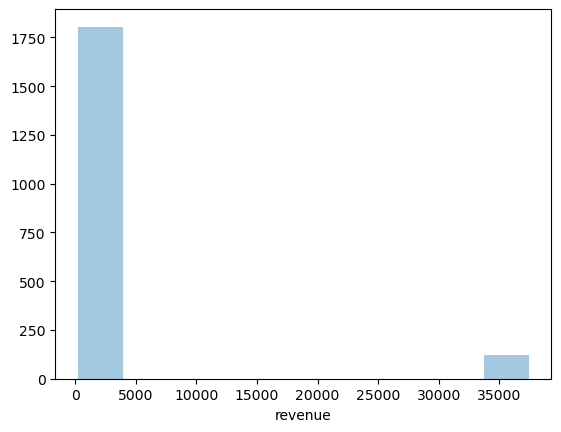

In [84]:
sns.distplot(df_a_group.query('revenue > 0').revenue, kde=False, bins=10)

/var/folders/jq/xsrks5ps78jbmh4p6prf04qw0000gn/T/ipykernel_38577/2286554871.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_b_group.query('revenue > 0').revenue, kde=False, bins=10)


<Axes: xlabel='revenue'>

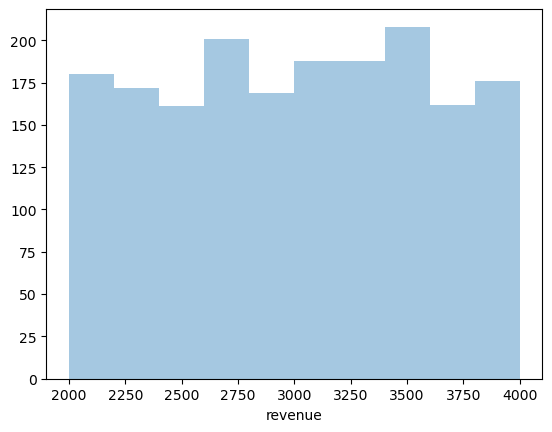

In [85]:
sns.distplot(df_b_group.query('revenue > 0').revenue, kde=False, bins=10)

In [139]:
df_a_group.query('revenue > 0').revenue.median()


311.0

In [140]:
df_b_group.query('revenue > 0').revenue.median()

3022.0

Анализируя графики выше и показатели медиан двух групп (контрольной и тестовой), можно поставить под сомнение корректность работы сплит-системы. В тестовой группе траты пользователей (доход игры) распределен равномерно, в то время, как в контрольной группе есть те, кто тратит минимум и те, кто тратит в несколько десятков раз больше, чем первая группа. 
Медианы отличаются в 10 раз. 
Однако иных данных нет, поэтмому проверим несколько показателей: конверсию (категориальный показатель) и два количественных показателя - ARPU и ARPPU. 

 Для сравнения ARPU будем использовать Т-тест, так как имеем дело с очень большими выборками и критерием нормальности в данном случае можно принебречь. Проверку распределений на нормальность можно пропустить. Принцип работы этого теста предполагает сравнение средних значений поэтому просто прогоним его по колонке revenue - это и получится сравнением ARPU

По графикам видим, что данные распределены не нормально, но в любом случае проведем тест Шапиро (несмотря на то, что данных много и можно пренебречь проверкой на нормальность) + проведем тест Левена для определения равенства дисперсий. 

**Тест Шапиро-Уилка** <br/>
Нулевая гипотеза: Данные распределены нормально. <br/>
Альтернативная гипотеза: Данные распределены не нормально. 

In [156]:
shapiro(df_a_group.revenue).pvalue

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

In [158]:
shapiro(df_b_group.revenue).pvalue

0.0

**Тест Левена** <br/>
Нулевая гипотеза: Дисперсии равны. <br/>
Альтернативная гипотеза: Дисперсии не равны.

In [161]:
levene(df_a_group.revenue, df_b_group.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

**Вывод:**

Данные распределены НЕ нормально, нет оснований полагать, что дисперсии в двух группах не равны. 

Теперь проверим данные, но для платящих пользователей (чтобы проверить метрику ARPPU). 

In [162]:
shapiro(df_a_group.loc[df_a_group.revenue > 0].revenue).pvalue

0.0

In [165]:
shapiro(df_b_group.loc[df_b_group.revenue > 0].revenue).pvalue

2.4928981530329e-22

In [166]:
levene(df_a_group.loc[df_a_group.revenue > 0].revenue, df_b_group.loc[df_b_group.revenue > 0].revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

**Вывод:**

Распределение не нормальное, имеются основания полагать, что дисперсии различаются.

T-тест Уэлча является вариантом t-теста для выборок, в ктр дисперсии не равны.  <br/> 
+ Поскольку у нас имееются достаточно большие выборки, то не стоит забывать про ЦПТ, ктр гласит, что распределение выборочного среднего будет приближаться к нормальному распределению, независимо от формы исходного распределения <br/> 
Так как конверсия это категориальное понятие, для ее проверки мы будем использовать хи-квадрат тест. <br/>

**Итог:** <br/>
1. для проверки ARPU ARPPU - T-тест Уэлча <br/>
2. для проверки конверсии - хи-квадрат. 

**1. Проверка конверсии** <br/>
Нулевая гипотеза: Конверсия одинаковая в группах. <br/>
Альтернативная гипотеза: Конверсия в платящих пользователей отличаются.

In [167]:
df_ab_test['payer'] = np.where(df_ab_test['revenue'] != 0, 1, 0)
chi2_contingency(pd.crosstab(df_ab_test.testgroup, df_ab_test.payer))

Chi2ContingencyResult(statistic=4.374729521260405, pvalue=0.03647561892312613, dof=1, expected_freq=array([[200239.10075104,   1863.89924896],
       [200797.89924896,   1869.10075104]]))

P-value = 0.036, что меньше уровня значимости 0.05. <br/>
Есть достаточные основания для отклонения нулевой гипотезы.

2. Проверка ARPU, ARPPU - t_test

In [168]:
ttest_ind(df_a_group.revenue, df_b_group.revenue, equal_var=False)

TtestResult(statistic=-0.6234876562792212, pvalue=0.5329647014130866, df=240991.13078245192)

P-value > 0.05. Значит нет стат. значимых оснований для отклонения нулевой гипотезы (ARPU не отличается в двух группах).

In [169]:
ttest_ind(df_a_group.loc[df_a_group.revenue > 0].revenue, df_b_group.loc[df_b_group.revenue > 0].revenue, equal_var=False)

TtestResult(statistic=-1.644630266430084, pvalue=0.10020780398916018, df=1943.4815217434643)

In [170]:
ttest_ind(df_a_group.loc[df_a_group.revenue > 0].revenue, df_b_group.loc[df_b_group.revenue > 0].revenue)

TtestResult(statistic=-1.5917100176862005, pvalue=0.11153459157259497, df=3731.0)

P-value > 0.05, опять нет оснований для отклонения нулевой гипотезы (ARPPU не различаются для двух групп).

## Итог ##

T-test не выявил стат. значимых различий ARPPU и ARPU  между контрольной и тестовой группами. <br/>
Хи-квадрат показал, что конверсия выше у контрольной группы, что можно признать стат. значимым различием. <br/>
Для начала следует проверить дизайн эксперимента и работу сплит-системы, проверить корректность предосталвений равных акций двум группам, а пока тестовой вариант не стоит выкатывать в продакшн версию.